# Proyecto Estructura y Bases de Datos
## Profesor: Miguel Cárcamo

Integrantes:
*   Antonia Morales
*   Ángel Paisano
*   Martín Raffo
*   Esteban Sánchez





# Introducción

El presente proyecto consiste en un análisis comparativo de dos data release (EDR3 y DR3) de la misión Gaia a través de herramientas propias de la ciencia de datos. Los datasets son cargados a Python utilizando la API Astroquery y procesados con ADQL (Astronomical Data Query Language, lenguaje idéntico a SQL pero con funciones integradas para trabajar datos astronómicos). Luego, con ellos, se pobla una base de datos SQL a la cual se le hacen consultas, para después elaborar gráficos que contribuyen a la interpretación de los resultados obtenidos.

Gaia es un telescopio espacial lanzado el año 2013 por la ESA (European Space Agency) cuyo propósito es construir el catálogo más grande y más completo posible del espacio. A la fecha, esta sonda ha logrado reunir datos de más de mil millones de objetos astronómicos de diversa índole como estrellas, planetas, quásares y más. En este caso, el objeto de estudio será la galaxia de la Gran Nube de Magallanes, que se encuentra a una distancia de alrededor de 50 kilopársecs de la Vía Láctea.

Para el proyecto es conveniente trabajar con SQL debido a la naturaleza de los datos: éstos son homogéneos, fácilmente organizables en tablas de tipo relacional y no variables en el tiempo. Cabe destacar que, si bien TaQL también es utilizado para bases de datos relacionales, tampoco es una elección adecuada en este contexto, puesto que su enfoque es trabajar información proveniente de observaciones en radio, mientras que los datos de Gaia se encuentran en la banda del óptico.


A continuación, se adjunta una imagen que contiene el modelo de la base de datos, que ilustra el flujo de los datos desde Gaia hasta la elaboración de gráficos en matplotlib.

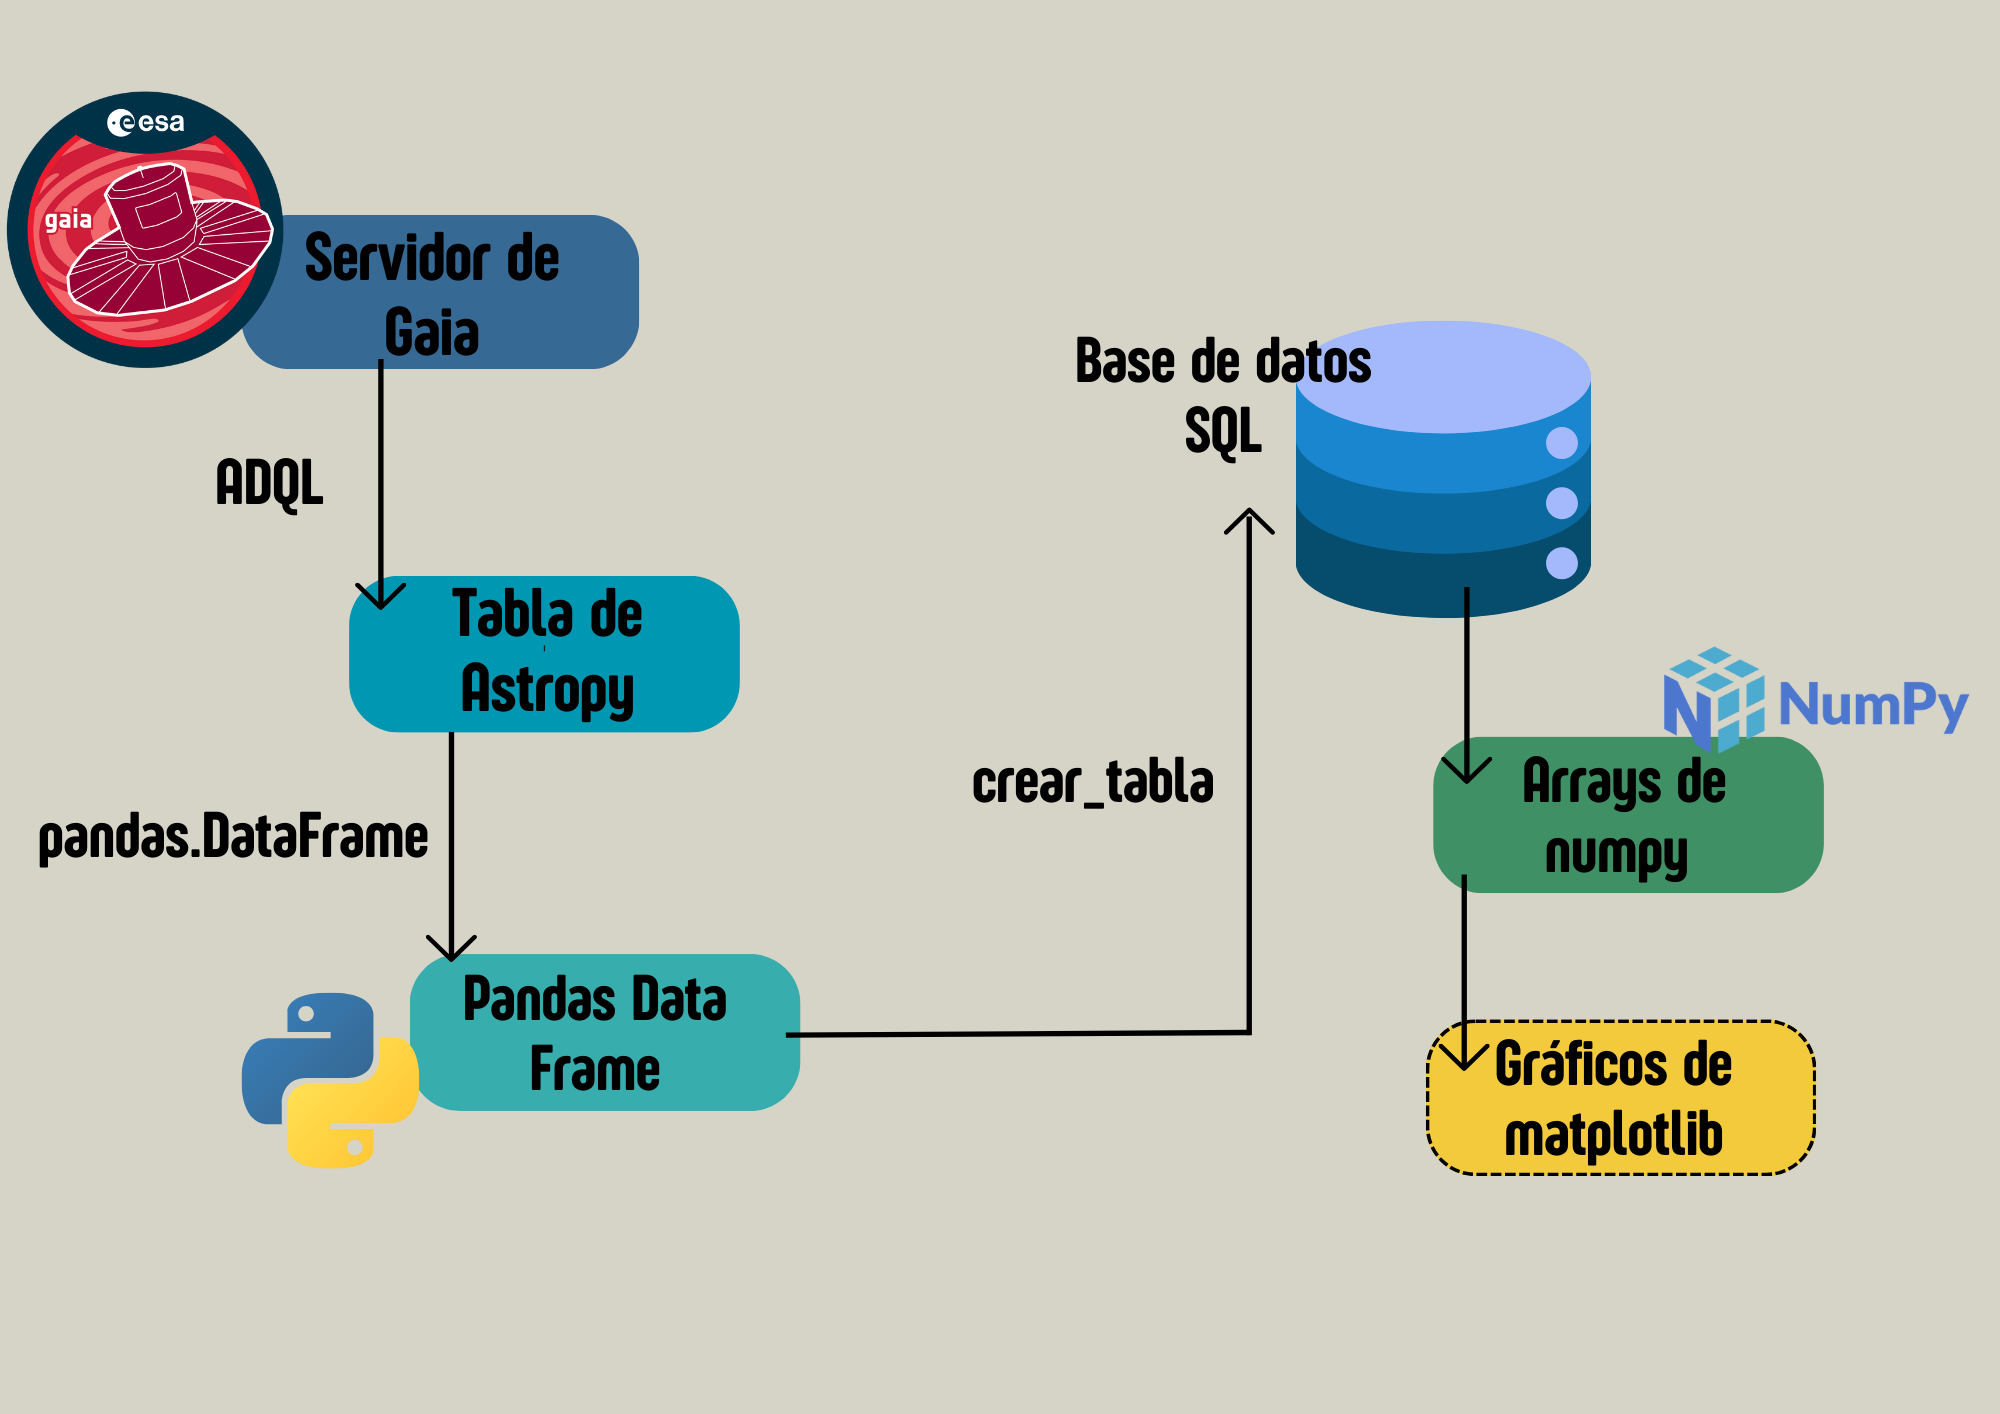

In [122]:
from IPython.display import Image
Image('Modelo.png')

También, se incluye el esquema de la base de datos, que ilustra las entidades existentes con sus respectivos atributos.

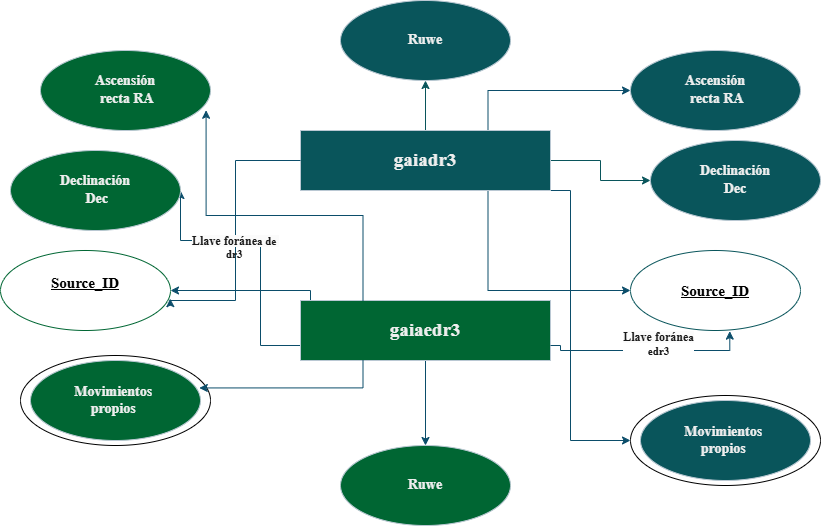

In [123]:
Image('esquema_bd.png')

# Gaia

In [ ]:
#Instalando astroquery
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 22.6 MB/s eta 0:00:00


In [ ]:
#Se importan librerías
from astroquery.gaia import Gaia
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Se cargan las tablas
tables = Gaia.load_tables(only_names=True)

INFO:astroquery:Retrieving tables...


INFO: Retrieving tables... [astroquery.utils.tap.core]


INFO:astroquery:Parsing tables...


INFO: Parsing tables... [astroquery.utils.tap.core]


INFO:astroquery:Done.


INFO: Done. [astroquery.utils.tap.core]


In [ ]:
#Se imprimen nombres de tablas
for table in tables:
    print(table.name)

external.apassdr9
external.catwise2020
external.gaiadr2_astrophysical_parameters
external.gaiadr2_geometric_distance
external.gaiaedr3_distance
external.gaiaedr3_gcns_main_1
external.gaiaedr3_gcns_rejected_1
external.gaiaedr3_spurious
external.gaia_eso_survey
external.galex_ais
external.lamost_dr9_lrs
external.lamost_dr9_mrs
external.ravedr5_com
external.ravedr5_dr5
external.ravedr5_gra
external.ravedr5_on
external.ravedr6
external.sdssdr13_photoprimary
external.skymapperdr1_master
external.skymapperdr2_master
external.tmass_xsc
external.xgboost_table1
external.xgboost_table2
gaiadr1.aux_qso_icrf2_match
gaiadr1.ext_phot_zero_point
gaiadr1.allwise_best_neighbour
gaiadr1.allwise_neighbourhood
gaiadr1.gsc23_best_neighbour
gaiadr1.gsc23_neighbourhood
gaiadr1.ppmxl_best_neighbour
gaiadr1.ppmxl_neighbourhood
gaiadr1.sdss_dr9_best_neighbour
gaiadr1.sdss_dr9_neighbourhood
gaiadr1.tmass_best_neighbour
gaiadr1.tmass_neighbourhood
gaiadr1.ucac4_best_neighbour
gaiadr1.ucac4_neighbourhood
gaiadr1.u

## ADQL
La muestra de la Gran Nube de Magallanes (siglas en inglés: LMC) se obtiene usando una selección con un radio de 20° alrededor de la coordenada $α,δ$ (81.28°, -67.78°). El trabajo se enfocará en esta región del cielo para procesar datos de la galaxia anteriormente mencionada, estudiando las posiciones en el cielo de las fuentes astronómicas, sus movimientos propios y las magnitudes en distintos filtros. Este paso está basado en el artículo científico de Luri et al (2021) que se dedica a seleccionar datos de Gaia EDR3 en la región de la LMC.

Después de hacer las consultas pertinentes en Gaia EDR3 y DR3 para obtener los datos de las fuentes en la región seleccionada, se guardan los resultados en tablas de Astropy.

In [103]:
# Consulta a Gaia y conversión (EDR3)
job0 = Gaia.launch_job_async("""SELECT TOP 100000 source_id, ra, dec, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag,
                      phot_rp_mean_mag, ruwe FROM gaiaedr3.gaia_source
                      WHERE DISTANCE(POINT(81.28, -69.78), POINT(ra, dec)) < 20
                      AND gaiaedr3.gaia_source.parallax IS NOT NULL""")
tabla_gaiaedr3 = job0.get_results()  # Resultado en formato Table de Astropy

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [104]:
tabla_gaiaedr3

source_id,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
,deg,deg,mas / yr,mas / yr,mag,mag,mag,
int64,float64,float64,float64,float64,float32,float32,float32,float32
4658236080911512448,78.5514024561908,-69.34938949564625,6.099950647710691,-4.440973490152747,19.420551,--,--,1.5995979
4755896455997449856,87.60944531792067,-65.6193910014861,1.1055655417649002,-1.9784777622983987,20.62418,20.731478,19.906069,1.1859884
4658827034041674496,78.98865728993457,-67.41405756228902,2.150618458910637,-0.271032618672317,20.68145,20.493795,19.83451,1.6031476
4650933945016145280,83.70880588880668,-71.88025885990012,-0.9666089941522282,15.613932418458852,20.78007,20.860954,19.187275,1.3682157
4661376286081623808,77.51696655431459,-68.43031122888497,-10.440825907151893,-31.305632330644006,20.754395,20.521837,19.563786,1.4107646
4654953725148442624,71.86570595395773,-70.03897514497481,-7.886638495915903,2.8751139249303614,20.789,20.77215,19.996368,1.30683
4661546263710670080,74.69473137406783,-68.08659493221936,1.927663826710482,5.956942478515257,20.841726,20.039173,19.522255,0.93420297
4656976689153527168,87.61868786729396,-70.59082891065862,-15.559220846507932,-1.9941102353106592,20.601223,19.848104,19.620773,1.3410082


In [105]:
# Consulta a Gaia y conversión (DR3)
job1 = Gaia.launch_job_async("""SELECT TOP 100000 source_id, ra, dec, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag,
                      phot_rp_mean_mag, ruwe FROM gaiadr3.gaia_source
                      WHERE DISTANCE(POINT(81.28, -69.78),POINT(ra, dec)) < 20
                      AND gaiadr3.gaia_source.parallax IS NOT NULL""")
tabla_gaiadr3 = job1.get_results()  # Resultado en formato Table de Astropy

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [106]:
tabla_gaiadr3

SOURCE_ID,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
,deg,deg,mas / yr,mas / yr,mag,mag,mag,
int64,float64,float64,float64,float64,float32,float32,float32,float32
4658236080911512448,78.5514024561908,-69.34938949564625,6.099950647710691,-4.440973490152747,19.420551,--,--,1.5995979
4755896455997449856,87.60944531792067,-65.6193910014861,1.1055655417649002,-1.9784777622983987,20.627981,20.731478,19.906069,1.1859884
4658827034041674496,78.98865728993457,-67.41405756228902,2.150618458910637,-0.271032618672317,20.684961,20.493795,19.83451,1.6031476
4650933945016145280,83.70880588880668,-71.88025885990012,-0.9666089941522282,15.613932418458852,20.776564,20.860954,19.187275,1.3682157
4661376286081623808,77.51696655431459,-68.43031122888497,-10.440825907151893,-31.305632330644006,20.757942,20.521837,19.563786,1.4107646
4654953725148442624,71.86570595395773,-70.03897514497481,-7.886638495915903,2.8751139249303614,20.792788,20.77215,19.996368,1.30683
4661546263710670080,74.69473137406783,-68.08659493221936,1.927663826710482,5.956942478515257,20.8444,20.039173,19.522255,0.93420297
4656976689153527168,87.61868786729396,-70.59082891065862,-15.559220846507932,-1.9941102353106592,20.60069,19.848104,19.620773,1.3410082


## Pandas

Ya teniendo las tablas de Astropy, se transforman a Dataframes de Pandas para eventualmente poblar con éstas una base de datos SQL y construir tablas de tipo relacional.


In [108]:
#Conversión de ADQL a Pandas (EDR3)
df_gaiaedr3 = tabla_gaiaedr3.to_pandas()
df_gaiaedr3 = df_gaiaedr3.rename(columns={"SOURCE_ID": "source_id"})

In [109]:
df_gaiaedr3

,source_id,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
0,4658236080911512448,78.551402,-69.349389,6.099951,-4.440973,19.420551,NaN,NaN,1.599598
1,4755896455997449856,87.609445,-65.619391,1.105566,-1.978478,20.624180,20.731478,19.906069,1.185988
2,4658827034041674496,78.988657,-67.414058,2.150618,-0.271033,20.681450,20.493795,19.834511,1.603148
3,4650933945016145280,83.708806,-71.880259,-0.966609,15.613932,20.780069,20.860954,19.187275,1.368216
4,4661376286081623808,77.516967,-68.430311,-10.440826,-31.305632,20.754395,20.521837,19.563786,1.410765
...,...,...,...,...,...,...,...,...,...
99995,4657893617471218304,83.034525,-70.236550,-2.801122,-4.480014,19.272133,18.855247,18.417500,2.090748
99996,5279734680582437504,92.380731,-69.215653,2.599397,-1.402853,20.684196,21.083527,20.404102,1.172152
99997,4660786982217476352,82.333518,-65.437197,-0.150200,-1.605936,20.791859,20.636160,20.368301,1.181278
99998,4650831625970626560,85.141312,-72.745979,6.976692,-1.859763,20.744085,20.699068,20.161112,1.093063


In [110]:
#Conversión de ADQL a Pandas (DR3)
df_gaiadr3 = tabla_gaiadr3.to_pandas()
df_gaiadr3 = df_gaiadr3.rename(columns={"SOURCE_ID": "source_id"})

In [111]:
df_gaiadr3

,source_id,ra,dec,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
0,4658236080911512448,78.551402,-69.349389,6.099951,-4.440973,19.420551,NaN,NaN,1.599598
1,4755896455997449856,87.609445,-65.619391,1.105566,-1.978478,20.627981,20.731478,19.906069,1.185988
2,4658827034041674496,78.988657,-67.414058,2.150618,-0.271033,20.684961,20.493795,19.834511,1.603148
3,4650933945016145280,83.708806,-71.880259,-0.966609,15.613932,20.776564,20.860954,19.187275,1.368216
4,4661376286081623808,77.516967,-68.430311,-10.440826,-31.305632,20.757942,20.521837,19.563786,1.410765
...,...,...,...,...,...,...,...,...,...
99995,4657893617471218304,83.034525,-70.236550,-2.801122,-4.480014,19.274088,18.855247,18.417500,2.090748
99996,5279734680582437504,92.380731,-69.215653,2.599397,-1.402853,20.684196,21.083527,20.404102,1.172152
99997,4660786982217476352,82.333518,-65.437197,-0.150200,-1.605936,20.791613,20.636160,20.368301,1.181278
99998,4650831625970626560,85.141312,-72.745979,6.976692,-1.859763,20.744085,20.699068,20.161112,1.093063


# SQL

Acto seguido, se define una función que permitirá la elaboración de tablas tipo SQL a partir de los Dataframes resultantes del paso anterior. Dicha función es ejecutada para EDR3 y DR3, a fin de poder realizar consultas y gráficos.

In [112]:
# Función para crear las Bases de Datos SQL en base a datos Gaia
def crear_tabla(tabla, nombre_tabla, db_name):
  """
  Esta función construye y pobla una base de datos SQL, para variables específicas
  con las que se van a trabajar. Y finalmente, comprueba si la base se pobló
  correctamente.

  Variables:

  -tabla (DataFrame): Nombre de la tabla tipo DataFrame desde donde se obtienen los datos.
  -nombre_tabla (String): Nombre de la tabla a crear .
  -db_name (String): Nombre de la base de datos a crear.
  """

  # Creación del cursor para manipular la base SQL
  db = sqlite3.connect(db_name)
  cur = db.cursor()

  # Creación de la base de datos a poblar
  cur.execute(f"""
        CREATE TABLE {nombre_tabla} (
            source_id INTEGER PRIMARY KEY AUTOINCREMENT,
            ra REAL,
            dec REAL,
            pmra REAL,
            pmdec REAL,
            phot_g_mean_mag REAL,
            phot_bp_mean_mag REAL,
            phot_rp_mean_mag REAL,
            ruwe REAL
        );
    """)

  # Proceso donde se pobla la Base de Datos SQL en base a los datos del DataFrame
  for i, row in tabla.iterrows():
        cur.execute(f"""
            INSERT OR IGNORE INTO {nombre_tabla} (source_id, ra, dec, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, ruwe)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
        """, (row['source_id'], row['ra'], row['dec'], row['pmra'], row['pmdec'], row['phot_g_mean_mag'], row['phot_bp_mean_mag'], row['phot_rp_mean_mag'], row['ruwe']))

  db.commit()

  # Verificación de la correcta creación de la base de datos.
  res = cur.execute(f"PRAGMA table_info({nombre_tabla})")
  if res.fetchall() != []:
    print("Tabla creada correctamente")
    print(res.fetchall())
  else:
    print("Error al crear la tabla")

  db.close()

In [114]:
#Creación de tablas con la función a partir de los datos de EDR3

crear_tabla(df_gaiaedr3, 'gaiaedr3', 'gaiaedr3.db')

Tabla creada correctamente
[]


In [115]:
#Creación de tablas con la función a partir de los datos de DR3
crear_tabla(df_gaiadr3, 'gaiadr3', 'gaiadr3.db')

Tabla creada correctamente
[]


# Querys SQL

Una vez ya se han creado las tablas de SQL, éstas pueden ser trabajadas en Python con un cursor de sqlite3. De este modo, se realizan diversas consultas relevantes para el problema.

In [116]:
#Creación de un objeto tipo cursor en sqlite3
db = sqlite3.connect('gaiaedr3.db')
cur = db.cursor()
cur.execute("ATTACH DATABASE 'gaiadr3.db' AS gaiadr3;")

In [117]:
#Verificación de los nombres de columnas y tipo de información de la tabla de EDR3
res = cur.execute(f"""PRAGMA table_info(gaiaedr3)""")
res.fetchall()

[(0, 'source_id', 'INTEGER', 0, None, 1),
 (1, 'ra', 'REAL', 0, None, 0),
 (2, 'dec', 'REAL', 0, None, 0),
 (3, 'pmra', 'REAL', 0, None, 0),
 (4, 'pmdec', 'REAL', 0, None, 0),
 (5, 'phot_g_mean_mag', 'REAL', 0, None, 0),
 (6, 'phot_bp_mean_mag', 'REAL', 0, None, 0),
 (7, 'phot_rp_mean_mag', 'REAL', 0, None, 0),
 (8, 'ruwe', 'REAL', 0, None, 0)]

In [124]:
#Consulta para conocer la cantidad de filas de las tablas
query0 = cur.execute(f"""SELECT COUNT(*) FROM gaiaedr3""")
print(f"Cantidad de datos en la selección de EDR3: {query0.fetchall()[0][0]}")

query01 = cur.execute(f"""SELECT COUNT(*) FROM gaiadr3""")
print(f"Cantidad de datos en la selección de DR3: {query01.fetchall()[0][0]}")

Cantidad de datos en la selección de EDR3: 99878
Cantidad de datos en la selección de DR3: 99878


In [125]:
#Consulta para conocer la cantidad de fuentes comunes entre EDR3 y DR3

query1 = cur.execute(f"""SELECT COUNT(*) FROM
                      (SELECT gaiaedr3.source_id AS source_id_gaiaedr3,
                      gaiadr3.source_id AS source_id_gaiadr3 FROM gaiaedr3
                      JOIN gaiadr3 ON gaiaedr3.source_id = gaiadr3.source_id)""")
print(f"Cantidad de datos encontrados en el cross-match: {query1.fetchall()[0][0]}")

Cantidad de datos encontrados en el cross-match: 99878


In [120]:
#Consulta para obtener número de columna e ID para cada fuente en EDR3 y DR3

query2 = cur.execute(f"""SELECT ROW_NUMBER() OVER(ORDER BY gaiaedr3.source_id) AS row_number,
                          gaiaedr3.source_id AS source_id_gaiaedr3,
                          gaiadr3.source_id AS source_id_gaiadr3
                        FROM gaiaedr3
                        JOIN gaiadr3
                        ON gaiaedr3.source_id = gaiadr3.source_id;""")

rows = query2.fetchall()
for row in rows:
    print(f"Numero de Columna: {row[0]}, GAIAEDR3 Source ID: {row[1]}, GAIADR3 Source ID: {row[2]}")

Streaming output truncated to the last 5000 lines.
Numero de Columna: 94879, GAIAEDR3 Source ID: 5278743372060696576, GAIADR3 Source ID: 5278743372060696576
Numero de Columna: 94880, GAIAEDR3 Source ID: 5278743475139905536, GAIADR3 Source ID: 5278743475139905536
Numero de Columna: 94881, GAIAEDR3 Source ID: 5278744505930050560, GAIADR3 Source ID: 5278744505930050560
Numero de Columna: 94882, GAIAEDR3 Source ID: 5278744505932273664, GAIADR3 Source ID: 5278744505932273664
Numero de Columna: 94883, GAIAEDR3 Source ID: 5278745536724234240, GAIADR3 Source ID: 5278745536724234240
Numero de Columna: 94884, GAIAEDR3 Source ID: 5278747048553712640, GAIADR3 Source ID: 5278747048553712640
Numero de Columna: 94885, GAIAEDR3 Source ID: 5278748663458601984, GAIADR3 Source ID: 5278748663458601984
Numero de Columna: 94886, GAIAEDR3 Source ID: 5278749453735574528, GAIADR3 Source ID: 5278749453735574528
Numero de Columna: 94887, GAIAEDR3 Source ID: 5278751927636346880, GAIADR3 Source ID: 527875192763634

In [126]:
#Consulta para obtener la cantidad de datos con magnitudes RP menores a 20 en ambos datasets
#Esto es de interés porque se desea conocer las fuentes más brillantes en la región
query3 = cur.execute("""SELECT COUNT(*) AS n FROM (SELECT gaiaedr3.source_id, gaiaedr3.phot_rp_mean_mag FROM gaiaedr3
                        JOIN gaiadr3 ON gaiaedr3.source_id = gaiadr3.source_id
                        WHERE gaiaedr3.phot_rp_mean_mag < 20)""")
print(f"Cantidad de fuentes con magnitud RP menor a 20: {query3.fetchall()[0][0]}")

Cantidad de fuentes con magnitud RP menor a 20: 36054


# Gráficos

Finalmente, a modo de poder interpretar los resultados de manera visual, se elaboran gráficos con distintas variables que se extraen de los datasets.

In [ ]:
#Fondo negro en los gráficos por motivos de estética
plt.style.use('dark_background')

In [ ]:
#Variables (EDR3)
ra_edr3 = df_gaiaedr3['ra']
dec_edr3 = df_gaiaedr3['dec']
pmra_edr3 = df_gaiaedr3['pmra']
pmdec_edr3 = df_gaiaedr3['pmdec']
mag_bp_edr3 = df_gaiaedr3['phot_bp_mean_mag']
mag_rp_edr3 = df_gaiaedr3['phot_rp_mean_mag']
mag_g_edr3 = df_gaiaedr3['phot_g_mean_mag']
ruwe_edr3 = df_gaiaedr3['ruwe']

In [ ]:
#Variables (DR3)
ra_dr3 = df_gaiadr3['ra']
dec_dr3 = df_gaiadr3['dec']
pmra_dr3 = df_gaiadr3['pmra']
pmdec_dr3 = df_gaiadr3['pmdec']
mag_bp_dr3 = df_gaiadr3['phot_bp_mean_mag']
mag_rp_dr3 = df_gaiadr3['phot_rp_mean_mag']
mag_g_dr3 = df_gaiadr3['phot_g_mean_mag']
ruwe_dr3 = df_gaiadr3['ruwe']

Después de obtenidas las variables deseadas de los datasets, los datos son filtrados por RUWE (Renormalised Unit Weight Error). Este parámetro es una normalización de la función chi cuadrado que funciona como una medida del error de los datos y será útil para hacer una limpieza de los mismos, logrando resultados más precisos. El criterio de hacer una selección para RUWE menor a 1.4 es un estándar que se ha adoptado como convención a la hora de trabajar con Gaia.

In [ ]:
#Selección de fuentes de EDR3 con un RUWE menor a 1.4
filtro_ruwe_edr3 = df_gaiaedr3['ruwe'] < 1.4
df_filtro_edr3 = df_gaiaedr3[filtro_ruwe_edr3]
df_filtro_edr3

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
1,4755896455997449856,87.609445,-65.619391,-29.754228,1.105566,-1.978478,20.624180,20.731478,19.906069,1.185988
3,4650933945016145280,83.708806,-71.880259,-26.940254,-0.966609,15.613932,20.780069,20.860954,19.187275,1.368216
5,4654953725148442624,71.865706,-70.038975,-22.578043,-7.886638,2.875114,20.789000,20.772150,19.996368,1.306830
6,4661546263710670080,74.694731,-68.086595,-22.476061,1.927664,5.956942,20.841726,20.039173,19.522255,0.934203
7,4656976689153527168,87.618688,-70.590829,-22.377690,-15.559221,-1.994110,20.601223,19.848104,19.620773,1.341008
...,...,...,...,...,...,...,...,...,...,...
99994,4657764214357813632,85.796404,-68.613786,-3.116910,0.703448,4.371127,20.779612,21.045977,20.445887,0.949053
99996,5279734680582437504,92.380731,-69.215653,-3.116888,2.599397,-1.402853,20.684196,21.083527,20.404102,1.172152
99997,4660786982217476352,82.333518,-65.437197,-3.116873,-0.150200,-1.605936,20.791859,20.636160,20.368301,1.181278
99998,4650831625970626560,85.141312,-72.745979,-3.116865,6.976692,-1.859763,20.744085,20.699068,20.161112,1.093063


In [ ]:
#Variables filtradas por RUWE (EDR3)

ra_edr3_filtro = df_filtro_edr3['ra']
dec_edr3_filtro = df_filtro_edr3['dec']
pmra_edr3_filtro = df_filtro_edr3['pmra']
pmdec_edr3_filtro = df_filtro_edr3['pmdec']
mag_g_edr3_filtro = df_filtro_edr3['phot_g_mean_mag']
mag_bp_edr3_filtro = df_filtro_edr3['phot_bp_mean_mag']
mag_rp_edr3_filtro = df_filtro_edr3['phot_rp_mean_mag']

In [ ]:
#Filtro por RUWE para DR3
filtro_ruwe_dr3 = df_gaiadr3['ruwe'] < 1.4
df_filtro_dr3 = df_gaiadr3[filtro_ruwe_dr3]
df_filtro_dr3

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
1,4755896455997449856,87.609445,-65.619391,-29.754228,1.105566,-1.978478,20.627981,20.731478,19.906069,1.185988
3,4650933945016145280,83.708806,-71.880259,-26.940254,-0.966609,15.613932,20.776564,20.860954,19.187275,1.368216
5,4654953725148442624,71.865706,-70.038975,-22.578043,-7.886638,2.875114,20.792788,20.772150,19.996368,1.306830
6,4661546263710670080,74.694731,-68.086595,-22.476061,1.927664,5.956942,20.844400,20.039173,19.522255,0.934203
7,4656976689153527168,87.618688,-70.590829,-22.377690,-15.559221,-1.994110,20.600691,19.848104,19.620773,1.341008
...,...,...,...,...,...,...,...,...,...,...
99994,4657764214357813632,85.796404,-68.613786,-3.116910,0.703448,4.371127,20.782845,21.045977,20.445887,0.949053
99996,5279734680582437504,92.380731,-69.215653,-3.116888,2.599397,-1.402853,20.684196,21.083527,20.404102,1.172152
99997,4660786982217476352,82.333518,-65.437197,-3.116873,-0.150200,-1.605936,20.791613,20.636160,20.368301,1.181278
99998,4650831625970626560,85.141312,-72.745979,-3.116865,6.976692,-1.859763,20.744085,20.699068,20.161112,1.093063


In [ ]:
#Variables filtradas por RUWE (DR3)

ra_dr3_filtro = df_filtro_dr3['ra']
dec_dr3_filtro = df_filtro_dr3['dec']
pmra_dr3_filtro = df_filtro_dr3['pmra']
pmdec_dr3_filtro = df_filtro_dr3['pmdec']
mag_g_dr3_filtro = df_filtro_dr3['phot_g_mean_mag']
mag_bp_dr3_filtro = df_filtro_dr3['phot_bp_mean_mag']
mag_rp_dr3_filtro = df_filtro_dr3['phot_rp_mean_mag']

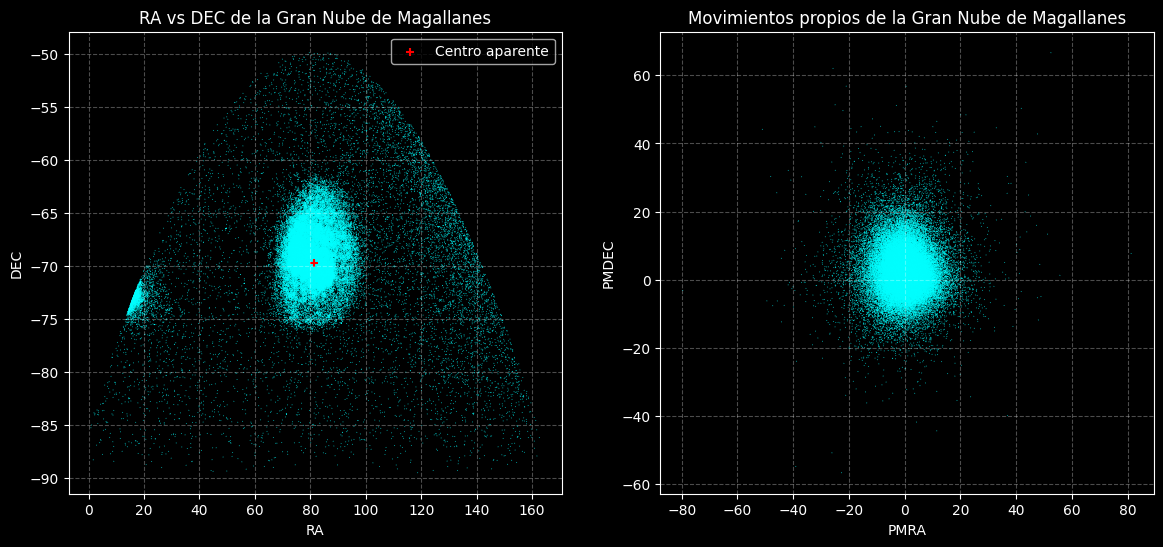

In [127]:
# Gráficos de posiciones y movimientos propios de DR3 (datos sin filtrar)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

ax1.scatter(ra_dr3, dec_dr3, c ='cyan', marker='*',s=1, edgecolors= "none")
ax1.scatter(81.28, -69.78, marker="+", facecolor="red",label='Centro aparente', s=40)
ax1.set_xlabel("RA")
ax1.set_ylabel("DEC")
ax1.set_title("RA vs DEC de la Gran Nube de Magallanes")
ax1.grid(ls='--', alpha=0.3)
ax1.legend()

ax2= fig.add_subplot(122)

ax2.scatter(pmra_dr3, pmdec_dr3, c='cyan', marker='*',s=1, edgecolors= "none")
ax2.set_xlabel("PMRA")
ax2.set_ylabel("PMDEC")
ax2.set_title("Movimientos propios de la Gran Nube de Magallanes")
ax2.grid(ls='--', alpha=0.3)
plt.show()

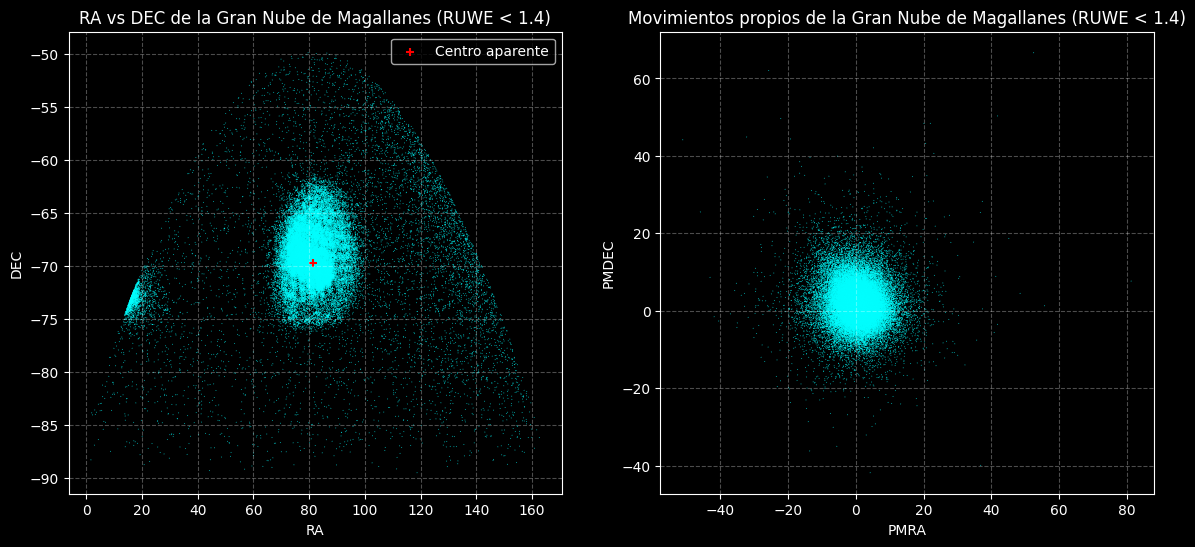

In [128]:
# Gráficos de posiciones y movimientos propios de DR3 (datos filtrados por RUWE)
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

ax1.scatter(ra_dr3_filtro, dec_dr3_filtro, c='cyan', marker='*',s=1, edgecolors= "none")
ax1.scatter(81.28, -69.78, marker="+", facecolor="red",label='Centro aparente', s=40)
ax1.set_xlabel("RA")
ax1.set_ylabel("DEC")
ax1.set_title("RA vs DEC de la Gran Nube de Magallanes (RUWE < 1.4)")
ax1.grid(ls='--', alpha=0.3)
ax1.legend()

ax2= fig.add_subplot(122)

ax2.scatter(pmra_dr3_filtro, pmdec_dr3_filtro, c='cyan', marker='*',s=1, edgecolors= "none")
ax2.set_xlabel("PMRA")
ax2.set_ylabel("PMDEC")
ax2.set_title("Movimientos propios de la Gran Nube de Magallanes (RUWE < 1.4)")
ax2.grid(ls='--', alpha=0.3)
plt.show()

Al observar los gráficos de posiciones y movimientos propios para DR3 con y sin filtro, es posible apreciar que no hay una gran diferencia para el caso de las posiciones, viéndose una distribución prácticamente idéntica en ambos casos. En tanto, para los movimientos propios, la distribución de los datos es similar, pero aquellos que no están filtrados parecen mostrar mayor scatter.

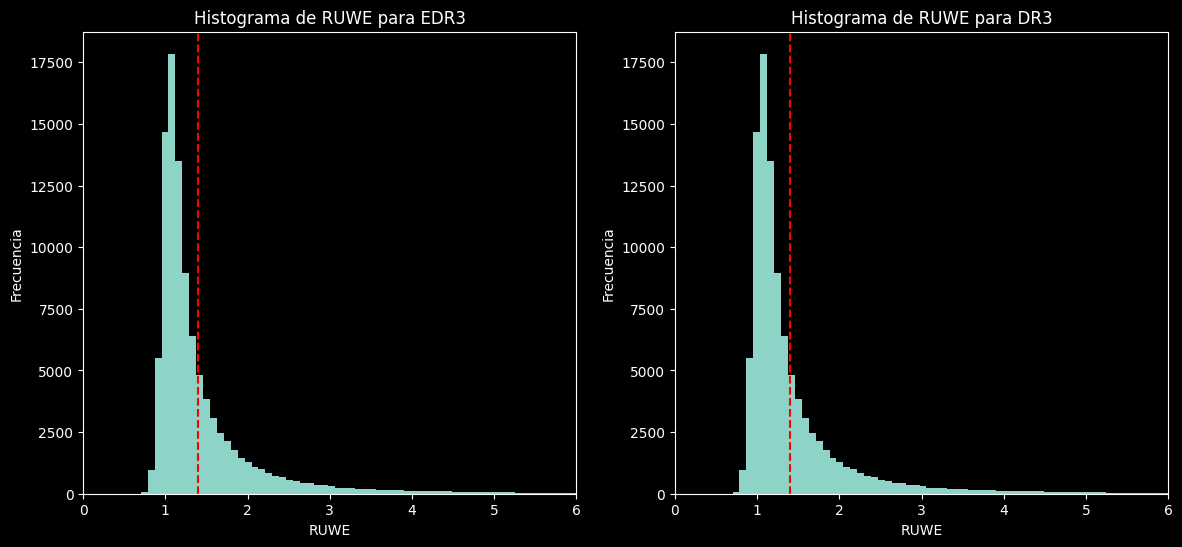

In [129]:
#Histograma de RUWE
# RUWE de EDR3
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)

ax1.hist(ruwe_edr3, bins = 500)
ax1.set_xlabel("RUWE")
ax1.set_ylabel("Frecuencia")
ax1.set_title("Histograma de RUWE para EDR3")
ax1.axvline(1.4, color = 'red', linestyle = "dashed") #Valor de corte para filtrar los datos
ax1.set_xlim(0,6)

# RUWE de DR3
ax2 = fig.add_subplot(122)

ax2.hist(ruwe_dr3, bins = 500)
ax2.set_xlabel("RUWE")
ax2.set_ylabel("Frecuencia")
ax2.set_title("Histograma de RUWE para DR3")
ax2.axvline(1.4, color = 'red', linestyle = "dashed") #Valor de corte para filtrar los datos
ax2.set_xlim(0,6)

plt.show()

Como se logra visualizar en los histogramas, la distribución de errores en EDR3 y DR3 presenta diferencias imperceptibles. Por ende, puede inferirse que la corrección de errores entre EDR3 y DR3 es mínima.

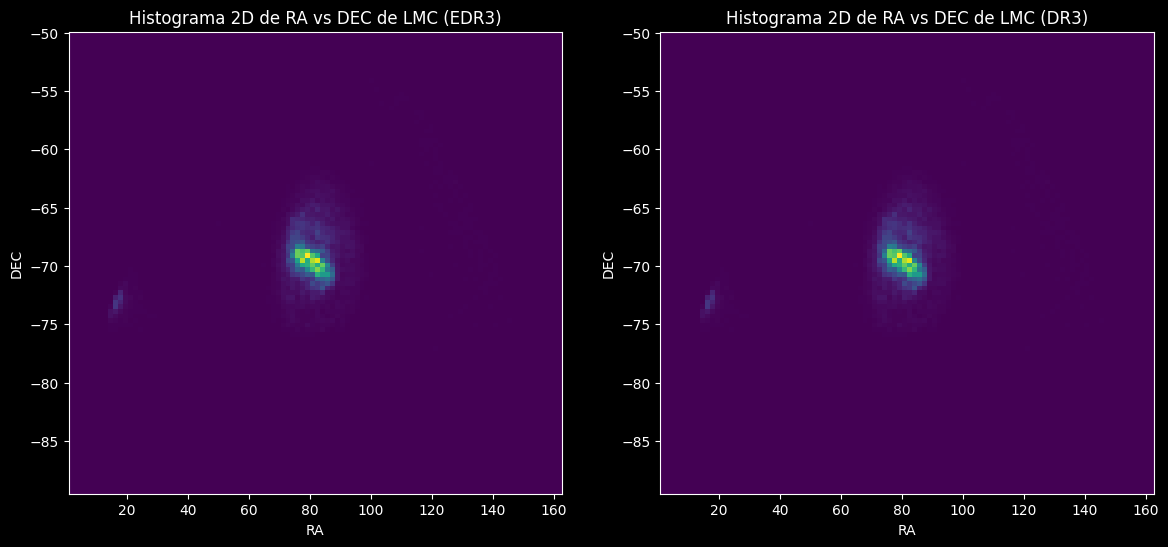

In [ ]:
#Histograma 2D de las posiciones (sin filtrar)

# Datos para EDR3
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)

ax1.hist2d(ra_edr3, dec_edr3, bins = 100)
ax1.set_xlabel("RA")
ax1.set_ylabel("DEC")
ax1.set_title("Histograma 2D de RA vs DEC de LMC (EDR3)")

# Datos para DR3
ax2= fig.add_subplot(122)

ax2.hist2d(ra_dr3, dec_dr3, bins = 100)
ax2.set_xlabel("RA")
ax2.set_ylabel("DEC")
ax2.set_title("Histograma 2D de RA vs DEC de LMC (DR3)")

plt.show()

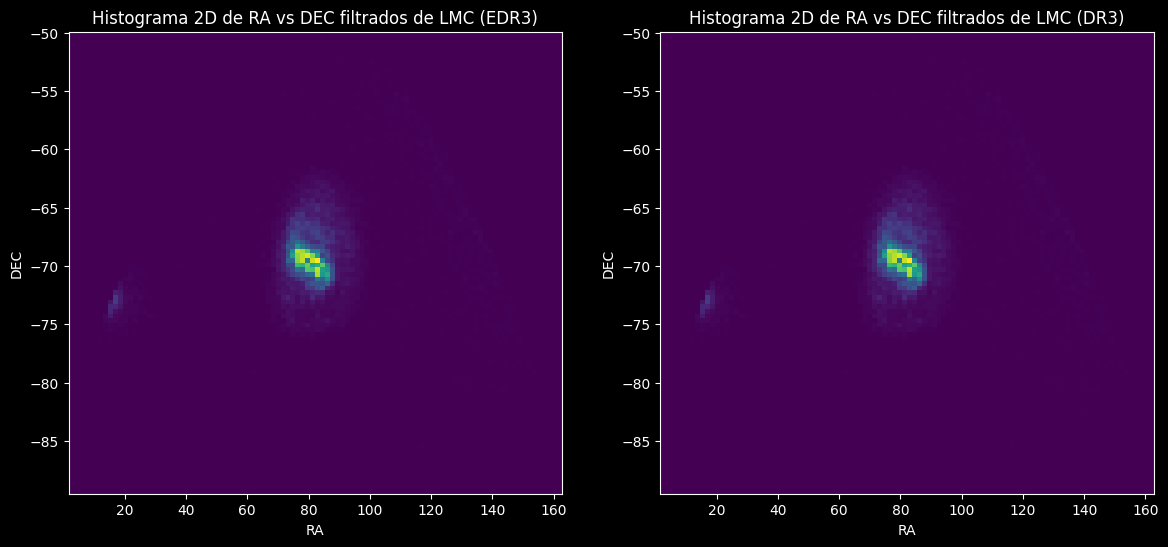

In [ ]:
#Histograma 2D de las posiciones (datos filtrados)

# Datos para EDR3
fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)

ax1.hist2d(ra_edr3_filtro, dec_edr3_filtro, bins = 100)
ax1.set_xlabel("RA")
ax1.set_ylabel("DEC")
ax1.set_title("Histograma 2D de RA vs DEC filtrados de LMC (EDR3)")

# Datos para DR3
ax2= fig.add_subplot(122)

ax2.hist2d(ra_dr3_filtro, dec_dr3_filtro, bins = 100)
ax2.set_xlabel("RA")
ax2.set_ylabel("DEC")
ax2.set_title("Histograma 2D de RA vs DEC filtrados de LMC (DR3)")

plt.show()

Comparando los resultados, tanto para EDR3 como DR3 y tomando en cuenta lo obtenido con y sin filtro por RUWE, puede verse que la diferencia más notable no es entre datasets (es decir, no hay un gran cambio entre EDR3 y DR3), sino que al observar cómo cambia la distribución de los datos filtrando o no por el RUWE.

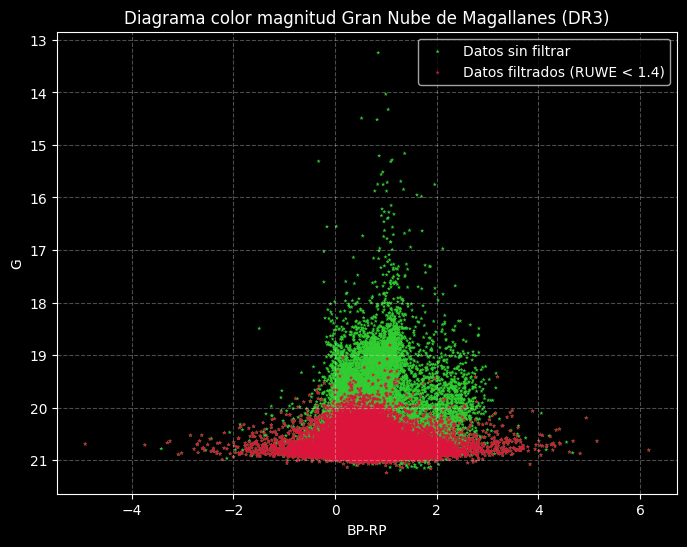

In [ ]:
#Diagrama color-magnitud de los datos (DR3)
fig = plt.figure(1, figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(mag_bp_dr3 - mag_rp_dr3, mag_g_dr3, c = 'limegreen' , marker = '*', s=10, edgecolors= "none", label = 'Datos sin filtrar')
ax1.scatter(mag_bp_dr3_filtro - mag_rp_dr3_filtro, mag_g_dr3_filtro, c = 'crimson', marker = '*', s=10, edgecolors= "none", label = 'Datos filtrados (RUWE < 1.4)')
ax1.set_xlabel("BP-RP")
ax1.set_ylabel("G")
ax1.set_title("Diagrama color magnitud Gran Nube de Magallanes (DR3)")
ax1.grid(ls='--', alpha=0.3)
ax1.legend()
plt.gca().invert_yaxis()

plt.show()

Es aquí donde se aprecia una mayor diferencia entre los datos. Al aplicar el filtro por RUWE, desaparecen las fuentes más brillantes (magnitudes G menor a 20, por inspección visual).

# Conclusión

En este trabajo se tomaron datos de EDR3 y DR3 de Gaia, con el fin de realizar un análisis de las principales propiedades de la Gran nube de Magallanes, en este caso, sus posiciones en el cielo, movimientos propios, paralajes y magnitudes. El trabajo se llevó a cabo utilizando la API astroquery para obtener los datos de Gaia y construyendo nuestra propia base de datos en SQL para realizar consultas elementales para comprender mejor el set de datos, ie: las fuentes más brillantes, realizar un filtro de las fuentes por su error, etc. Posteriormente al realizar gráficos de estas propiedades extraemos que entre EDR3 y DR3 no se presentan diferencias significativas. A partir del proyecto concluimos que SQL es una herramienta apropiada para tener más control sobre este tipo de datos astronómicos, lo que permite consultas más intuitivas.
